In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
%matplotlib inline

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from sklearn.linear_model import LinearRegression,HuberRegressor, Lasso, Ridge, ElasticNet, LassoCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import statsmodels.api as sm
import statsmodels.formula.api as smf


# Load specific time series forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from statsmodels.tsa.stattools import adfuller

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# ZRI data engineering

In [2]:
zri=pd.read_csv("zipcodes/Zip_Zri_AllHomesPlusMultifamily.csv")

In [3]:
zri['missing_percent']=zri.isnull().sum(axis=1)/zri.shape[1]*100

In [4]:
zri.shape

(13181, 121)

In [5]:
zri.isnull().sum(axis=0).sort_values(ascending = False)

2010-10            3851
2010-11            2742
2010-12            2595
2011-01            2588
2011-03            2572
                   ... 
City                  0
missing_percent       0
CountyName            0
SizeRank              0
RegionID              0
Length: 121, dtype: int64

In [6]:
zri_nomissing=zri.loc[zri.missing_percent==0]

In [7]:
zri_nomissing.columns.values

array(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01',
       '2011-02', '2011-03', '2011-04', '2011-05', '2011-06', '2011-07',
       '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01',
       '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07',
       '2012-08', '2012-09', '2012-10', '2012-11', '2012-12', '2013-01',
       '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07',
       '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01',
       '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07',
       '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01',
       '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07',
       '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01',
       '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07',
       '2016-08', '2016-09', '2016-10', '2016-11',

# Timeseries Analysis

In [9]:
zri_melt_cols=['2010-09', '2010-10', '2010-11', '2010-12', '2011-01',
       '2011-02', '2011-03', '2011-04', '2011-05', '2011-06', '2011-07',
       '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01',
       '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07',
       '2012-08', '2012-09', '2012-10', '2012-11', '2012-12', '2013-01',
       '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07',
       '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01',
       '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07',
       '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01',
       '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07',
       '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01',
       '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07',
       '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01',
       '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07',
       '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01',
       '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01',
       '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
       '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01']

In [10]:
zri_melt=zri_nomissing.melt(id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName']
                   ,value_vars=zri_melt_cols)

In [11]:
zri_melt.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'variable', 'value'],
      dtype='object')

In [12]:
zri_melt=zri_melt.rename(columns={"variable": "Date", "value": "Rent"})

In [13]:
zri_melt['Date']=pd.to_datetime(zri_melt['Date']).dt.to_period('M')
#zri_melt['Date']=pd.to_datetime(zri_melt['Date'])

In [14]:
zri_melt.dtypes

RegionID          int64
RegionName        int64
City             object
State            object
Metro            object
CountyName       object
Date          period[M]
Rent            float64
dtype: object

In [15]:
zri_melt.set_index('Date',inplace=True)

In [16]:
zri_melt.index.freq='MS'

In [17]:
zri_melt['Rent']=zri_melt['Rent'].astype(int)

## New York Data

In [18]:
# select a zipcode(11428) to run the model upon

zri_ny_11428 = zri_melt.loc[(zri_melt.City=='New York') & (zri_melt.index >= '2011') 
                      & (zri_melt.index < '2020')
                     & (zri_melt.RegionName==11428)]

In [54]:
#zri_ny_11428.sort_values(by='Date').head(60)

### Plot the source data

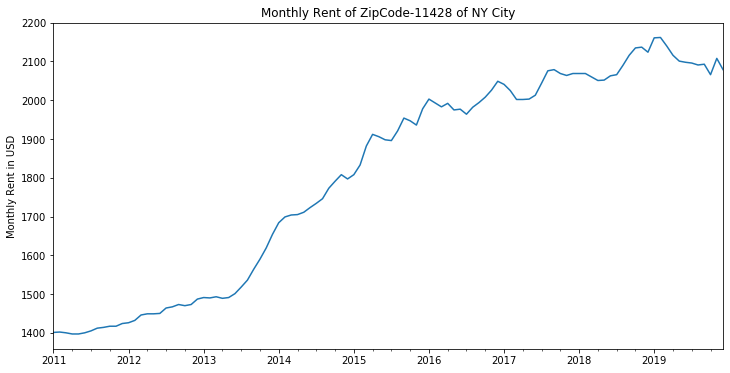

In [21]:
title = 'Monthly Rent of ZipCode-11428 of NY City'
ylabel='Monthly Rent in USD'
xlabel='' # we don't really need a label here

ax = zri_ny_11428['Rent'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

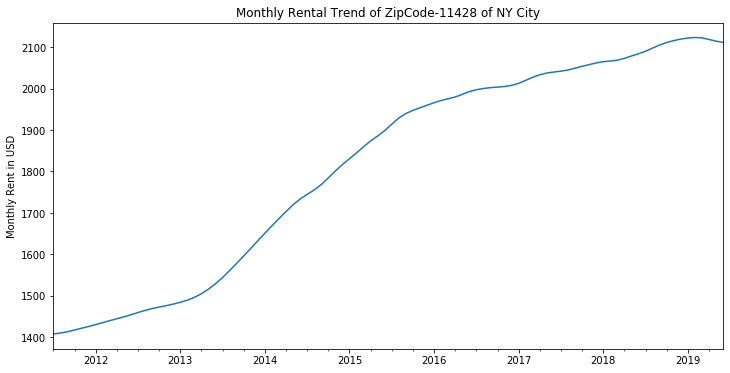

In [46]:
ets = seasonal_decompose(zri_ny_11428['Rent'], model='additive',period=12)

title = 'Monthly Rental Trend of ZipCode-11428 of NY City'
ylabel='Monthly Rent in USD'
xlabel='' # we don't really need a label here

ax = ets.trend.plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

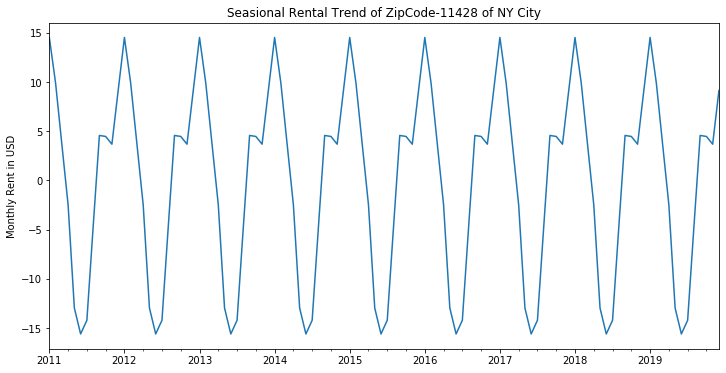

In [44]:
title = 'Seasional Rental Trend of ZipCode-11428 of NY City'
ylabel='Monthly Rent in USD'
xlabel='' # we don't really need a label here

ax = ets.seasonal.plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

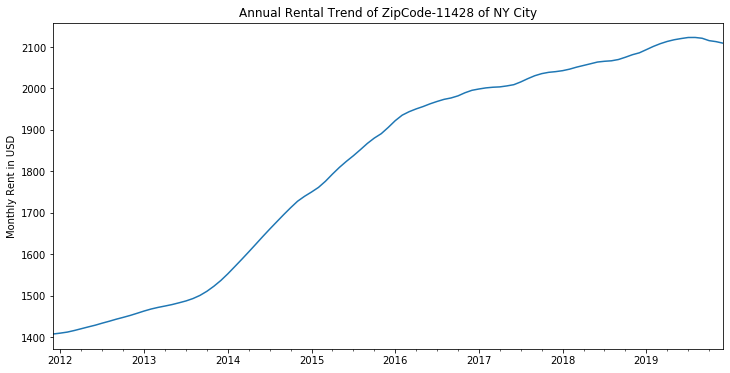

In [53]:
title = 'Annual Rental Trend of ZipCode-11428 of NY City'
ylabel='Monthly Rent in USD'
xlabel='' # we don't really need a label here

ax = zri_ny_11428.rolling(window=12).mean()['Rent'].plot(figsize=(12,6),title=title)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

<Figure size 1296x432 with 0 Axes>

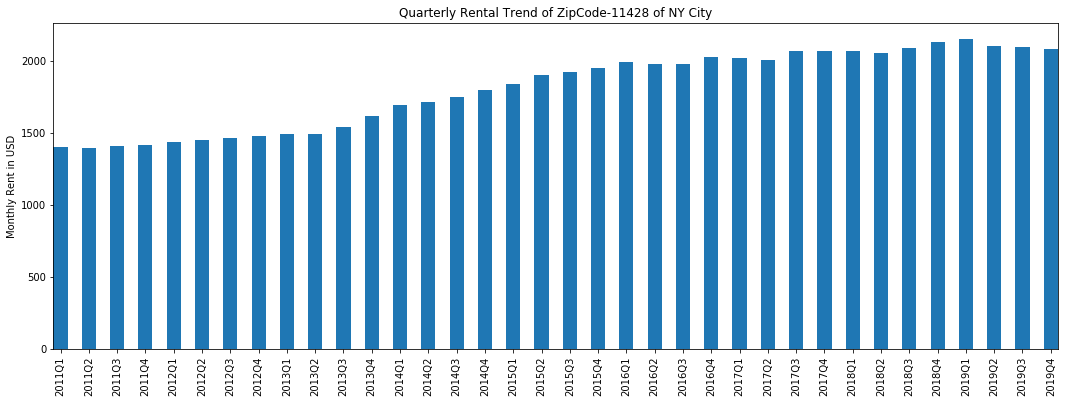

<Figure size 1296x432 with 0 Axes>

In [52]:
title = 'Quarterly Rental Trend of ZipCode-11428 of NY City'
ylabel='Monthly Rent in USD'
xlabel='' # we don't really need a label here

ax = zri_ny_11428['Rent'].resample('Q').mean().plot.bar(figsize=(18,6),title=title)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);
plt.figure(figsize=(18,6))

## Automate the augmented Dickey-Fuller Test

In [59]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("\n Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

### Run the augmented Dickey-Fuller Test to confirm stationarity

In [60]:
adf_test(zri_ny_11428['Rent'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.337757
p-value                   0.611727
# lags used               1.000000
# observations          106.000000
critical value (1%)      -3.493602
critical value (5%)      -2.889217
critical value (10%)     -2.581533

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders

In [67]:
auto_arima(zri_ny_11428['Rent'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -440.230
Date:                Wed, 25 Mar 2020   AIC                            886.461
Time:                        18:05:12   BIC                            894.479
Sample:                             0   HQIC                           889.711
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2781      1.643      2.603      0.009       1.057       7.499
ar.L1          0.3064      0.082      3.750      0.000       0.146       0.467
sigma2       219.1531     29.126      7.524      0.000     162.067     276.239
===================================================================================
Ljung-Box (Q):                       29.62   Jarque-Bera (JB):                 7.35
Prob(Q):                              0.89   Prob(JB):                         0.03
Heteroskedasticity (H):               4.98   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Run the ACF and PACF plots

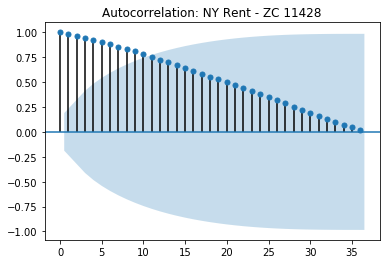

In [62]:
title = 'Autocorrelation: NY Rent - ZC 11428'
lags = 36
plot_acf(zri_ny_11428['Rent'],title=title,lags=lags);

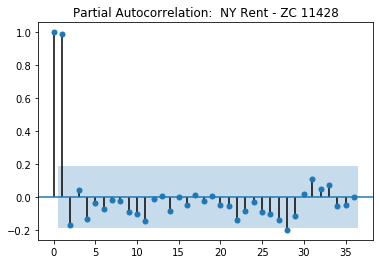

In [63]:
title = 'Partial Autocorrelation:  NY Rent - ZC 11428'
lags = 36
plot_pacf(zri_ny_11428['Rent'],title=title,lags=lags);

### Stepwise AUTO_ARIMA to find best AR and MA orders

In [68]:
stepwise_fit = auto_arima(zri_ny_11428['Rent'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=6,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(1, 0, 1, 6) (constant=True); AIC=896.774, BIC=907.465, Time=0.143 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 6) (constant=True); AIC=894.563, BIC=899.909, Time=0.006 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 6) (constant=True); AIC=888.260, BIC=898.951, Time=0.054 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 6) (constant=True); AIC=888.947, BIC=899.639, Time=0.062 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 6) (constant=False); AIC=909.046, BIC=911.719, Time=0.006 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 6) (constant=True); AIC=886.461, BIC=894.479, Time=0.028 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 1, 6) (constant=True); AIC=888.289, BIC=898.980, Time=0.041 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 1, 6) (constant=True); AIC=889.301, BIC=902.666, Time=0.111 seconds
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 6) (constant=True); AIC=888.292, BIC=898.983, Time=0.047 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 6) (constant=True); AIC=888.341, BIC=899.032, Time=0.035 seco

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -440.230
Date:                Wed, 25 Mar 2020   AIC                            886.461
Time:                        18:09:43   BIC                            894.479
Sample:                             0   HQIC                           889.711
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2781      1.643      2.603      0.009       1.057       7.499
ar.L1          0.3064      0.082      3.750      0.000       0.146       0.467
sigma2       219.1531     29.126      7.524      0.000     162.067     276.239
===================================================================================
Ljung-Box (Q):                       29.62   Jarque-Bera (JB):                 7.35
Prob(Q):                              0.89   Prob(JB):                         0.03
Heteroskedasticity (H):               4.98   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Best AIC score from above test
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=886.461, BIC=894.479, Time=0.037 seconds

### Split the data into train/test sets

In [69]:
len(zri_ny_11428)

108

In [70]:
# zri_ny_11428.iloc[60:96]
# zri_ny_11428.iloc[96:]

In [71]:
# Set one year for testing
train = zri_ny_11428.iloc[60:96]
test = zri_ny_11428.iloc[96:]

### Fit an ARIMA(1,1,0) Model

In [72]:
model = ARIMA(train['Rent'],order=(1,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Rent   No. Observations:                   35
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -138.322
Method:                       css-mle   S.D. of innovations             12.549
Date:                Wed, 25 Mar 2020   AIC                            282.645
Time:                        18:10:16   BIC                            287.311
Sample:                    02-29-2016   HQIC                           284.255
                         - 12-31-2018                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.7487      3.894      0.706      0.480      -4.883      10.380
ar.L1.D.Rent     0.4653      0.152      3.069      0.002       0.168       0.762
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1492           +0.0000j            2.1492            0.0000
-----------------------------------------------------------------------------
"""

In [78]:
# Obtain predicted values for the duration of test set - 2019
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,0) Predictions')

In [79]:
start

36

In [80]:
end

47

In [81]:
predictions

2019-01    2119.421085
2019-02    2118.760356
2019-03    2119.922690
2019-04    2121.933264
2019-05    2124.338510
2019-06    2126.927390
2019-07    2129.601711
2019-08    2132.315787
2019-09    2135.048360
2019-10    2137.789539
2019-11    2140.534723
2019-12    2143.281770
Freq: M, Name: ARIMA(1,1,0) Predictions, dtype: float64

In [82]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Rent'][i]}")

predicted=2119.421085, expected=2161
predicted=2118.760356, expected=2162
predicted=2119.92269 , expected=2140
predicted=2121.933264, expected=2116
predicted=2124.33851 , expected=2101
predicted=2126.92739 , expected=2098
predicted=2129.601711, expected=2096
predicted=2132.315787, expected=2091
predicted=2135.04836 , expected=2093
predicted=2137.789539, expected=2066
predicted=2140.534723, expected=2108
predicted=2143.28177 , expected=2079


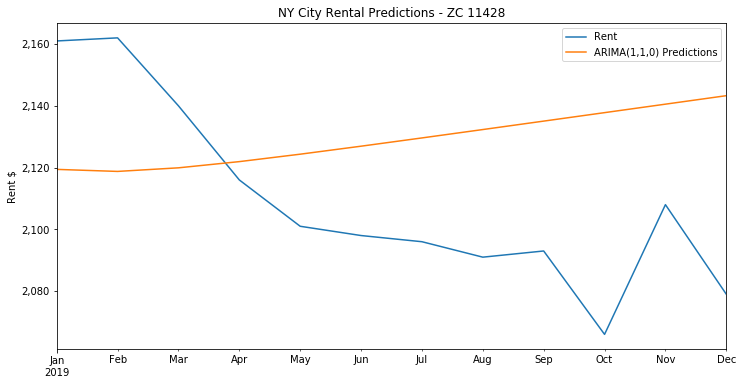

In [83]:
# Plot predictions against known values
title = 'NY City Rental Predictions - ZC 11428'
ylabel='Rent $'
xlabel='' # we don't really need a label here

# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

ax = test['Rent'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Evaluate the Model

In [84]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Rent'], predictions)
print(f'ARIMA(1,1,0) MSE Error: {error:11.10}')

ARIMA(1,1,0) MSE Error: 1697.231737


In [85]:
test['Rent'].mean()

2109.25

In [86]:
predictions.mean()

2129.1562653836086

In [89]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Rent'], predictions)
print(f'ARIMA(1,1,0) RMSE Error: {error:11.10}')

ARIMA(1,1,0) RMSE Error: 41.19747246


### Retrain the model on the full data, and forecast the future

In [90]:
model = ARIMA(zri_ny_11428['Rent'],order=(1,1,0))
results = model.fit()
fcast = results.predict(len(zri_ny_11428),len(zri_ny_11428)+11,typ='levels').rename('ARIMA(1,1,0) Forecast')

In [92]:
fcast

2020-01    2074.391917
2020-02    2077.258835
2020-03    2082.416496
2020-04    2088.276165
2020-05    2094.350966
2020-06    2100.491696
2020-07    2106.652630
2020-08    2112.819756
2020-09    2118.988779
2020-10    2125.158384
2020-11    2131.328167
2020-12    2137.498004
Freq: M, Name: ARIMA(1,1,0) Forecast, dtype: float64

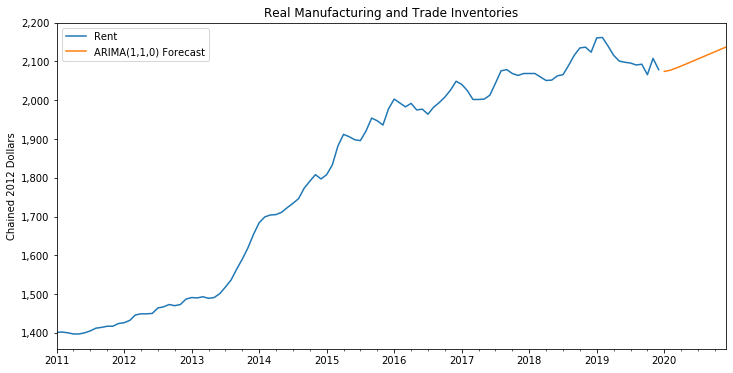

In [91]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = zri_ny_11428['Rent'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);